In [31]:
!pip install torch torchvision torchaudio
!pip install tensorflow


In [32]:
import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
from shutil import copyfile
import tensorflow as tf
# import torch
import torch
import torch.nn as nn
import torch.optim as Adam
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# !unzip "/content/drive/MyDrive/BRAIT/dataset-BRAIT.zip"

In [35]:
torch.cuda.is_available()

False

In [36]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [37]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
        ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
        ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
        ]),
}

In [38]:
# Define the data directory
data_dir = '/Users/apple/Documents/PROJECTS/Braille_Translator/BRAIT-Machine-Learning-main/Dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

In [39]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True) for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 12805, 'validation': 1602}


['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [40]:
print(f'Number of batches in the training set: {int(13171 / 20)}')
print(f'Number of batches in the training set: {int(1648 / 20)}')

Number of batches in the training set: 658
Number of batches in the training set: 82


In [41]:
trainloader = torch.utils.data.DataLoader(image_datasets, batch_size=20,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(image_datasets, batch_size=5,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(image_datasets, batch_size=5,
                                         shuffle=False)

In [42]:
import torch.nn.functional as F

class BRAIT_CNN(nn.Module):
  def __init__(self):
    super(BRAIT_CNN, self).__init__()
    self.brait1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.01))
    self.brait2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.01))
    self.brait3 = nn.Sequential(
        nn.Linear(32*7*7, 100),
        nn.Linear(100, 26))

  def forward(self, x):
    y = F.relu(self.brait1(x))
    y = F.relu(self.brait2(y))

    #flatten
    y = y.view(-1, 32*7*7)
    y = F.relu(self.brait3(y))

    return y

In [43]:
model = BRAIT_CNN()

In [44]:
# print summary of the neural network model to check if everything is fine.
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))

BRAIT_CNN(
  (brait1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=26, bias=True)
  )
)
# parameter:  173574


In [45]:
model.to(device)

BRAIT_CNN(
  (brait1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=26, bias=True)
  )
)

In [46]:
# Define the learning rate, loss function, and optimizer
from torch import optim
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
# Training loop
num_epochs = 15

# Initialize empty lists to store training loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Save the loss and accuracy values
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()

print("Training complete!")

train Loss: 0.2044 Acc: 0.9405

validation Loss: 0.3071 Acc: 0.9326

train Loss: 0.2158 Acc: 0.9403

validation Loss: 0.2834 Acc: 0.9351

train Loss: 0.2033 Acc: 0.9398

validation Loss: 0.2781 Acc: 0.9351

train Loss: 0.1955 Acc: 0.9425

validation Loss: 0.2623 Acc: 0.9382

train Loss: 0.2264 Acc: 0.9354

validation Loss: 0.2712 Acc: 0.9332

train Loss: 0.2262 Acc: 0.9356

validation Loss: 0.2494 Acc: 0.9376

train Loss: 0.2127 Acc: 0.9378

validation Loss: 0.2806 Acc: 0.9345

train Loss: 0.2325 Acc: 0.9366

validation Loss: 0.2600 Acc: 0.9326

train Loss: 0.2210 Acc: 0.9392

validation Loss: 0.2510 Acc: 0.9432

train Loss: 0.1895 Acc: 0.9437

validation Loss: 0.2630 Acc: 0.9401

train Loss: 0.1991 Acc: 0.9421

validation Loss: 0.2699 Acc: 0.9432

train Loss: 0.2098 Acc: 0.9402

validation Loss: 0.2418 Acc: 0.9370

train Loss: 0.1904 Acc: 0.9434

validation Loss: 0.3034 Acc: 0.9363

train Loss: 0.2291 Acc: 0.9373

validation Loss: 0.3161 Acc: 0.9338

train Loss: 0.2198 Acc: 0.9393

va

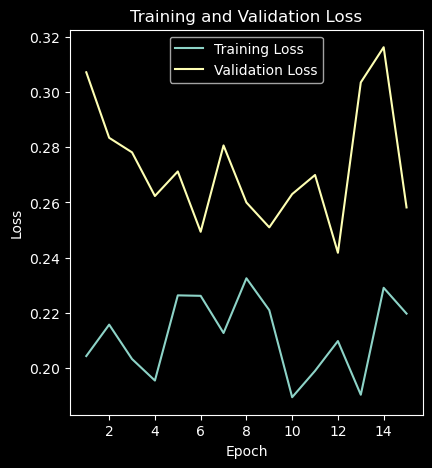

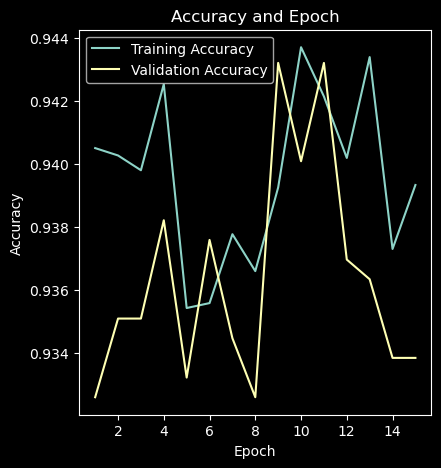

In [61]:
# Plotting
plt.figure(figsize=(10, 5))

# Plotting training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy and Epoch')
plt.legend()
plt.show()

In [62]:
# Save the model
torch.save(model.state_dict(), 'BRAILLE_PYTORCH_v2.pth')